In [1]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
import matplotlib.pyplot as plt
import time
from kornia.enhance.histogram import histogram2d
from bmadx.track import *
tkwargs = {
    "dtype" : torch.double
}
np.set_printoptions(precision= 16, suppress=False)
torch.set_printoptions(precision= 16, sci_mode=True)
torch.__version__, np.__version__
%config InlineBackend.figure_format = 'retina'

In [2]:
c_light = 2.99792458e8 #speed of light in m/s
m_e = 0.510998950e6 #electron mass in eV

In [3]:
def torchquadrupole(L: torch.Tensor, K1: torch.Tensor, NUM_STEPS=1,
                    X_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                    Y_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                    TILT: torch.Tensor=torch.tensor(0.0,**tkwargs)):
    return Quadrupole(L=L, K1=K1, NUM_STEPS=NUM_STEPS, X_OFFSET=X_OFFSET,
                     Y_OFFSET=Y_OFFSET, TILT=TILT)

# Offset estimation  


In this example, we want to find the offsets of the quadrupoles in a beamline given the 2D beam profile downstream.  
First, lets start by optimizing a quadrupole triple with random offsets: 

In [4]:
# Incoming particle
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 
tvec = torch.tensor(pvec1, **tkwargs)
p_in = Particle(*tvec, s, tp0c, mc2)

In [5]:
k1s_opt = np.array([-26.939869975743193,  14.286581926163615, -16.95284767969912 ])

In [6]:
# k1s used to get offsets. Each quadrupole strength is increased once from the optimal configuration. 
epsilon = 0.2 # strength change precentage
k1s_tests = []
for i in range(3):
    k1s_tests.append(k1s_opt.copy())
    
k1s_tests[0][0]=k1s_opt[0]*(1+epsilon)
k1s_tests[1][1]=k1s_opt[1]*(1+epsilon/2)
k1s_tests[2][2]=k1s_opt[2]*(1+epsilon)

k1s_tests

[array([-32.32784397089183 ,  14.286581926163615, -16.95284767969912 ]),
 array([-26.939869975743193,  15.715240118779978, -16.95284767969912 ]),
 array([-26.939869975743193,  14.286581926163615, -20.34341721563894 ])]

In [7]:
def train_model(model, training_iter, alpha=0.1):
    history_param = [None] * training_iter
    history_loss = [None] * training_iter
    # print the trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), alpha)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Calc loss and backprop gradients
        loss = model()  # loss is just O.F.
        loss.backward()
        if i%100==0: #print each 10 steps
            print('Iter %d/%d - Loss: %.5f '% (
                i + 1, training_iter, loss.item()
            ))
        #for param in model.parameters():
        #    history_param[i] = param.data.detach().numpy().copy()
        #for param in named_parameters():
        testlist = list(model.named_parameters())
        testdict = dict(testlist)
        for param in testlist:
            testdict[param[0]] = testdict[param[0]].data.detach().numpy().copy()
        history_param[i] = testdict
        history_loss[i] = loss.detach().numpy().copy()
        optimizer.step()
        
    return np.asarray(history_param), np.asarray(history_loss)

## Ground truth offset

In [8]:
# random ground truth offsets:
torch.manual_seed(0)
offsets_x_true = torch.normal(mean=0, std=1e-2, size=(3,), **tkwargs)
offsets_y_true = torch.normal(mean=0, std=1e-2, size=(3,), **tkwargs)
offsets_x_true, offsets_y_true

(tensor([1.5409961082440433e-02, -2.9342890576094637e-03, -2.1787893820745575e-02],
        dtype=torch.float64),
 tensor([5.6843127728066776e-03, -1.0845223424240210e-02, -1.3985953953708767e-02],
        dtype=torch.float64))


## Finding offsets

In [9]:
L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(L=L_d)

# outgoing bunch with true offsets for each set of k1s
p_out_tests = []
for test in range(len(k1s_tests)):
    k1s = k1s_tests[test]
    lattice = [drift]
    for i in range(len(k1s)):
        lattice.append( torchquadrupole(L=L_q, K1=k1s[i], X_OFFSET=offsets_x_true[i],
                                  Y_OFFSET=offsets_y_true[i]) )
        lattice.append( drift )
    p_out_tests.append( track_a_lattice(p_in, lattice)[-1] )
    
def get_centroid_diff(k1s, offsets_x, offsets_y, p_out_test, bandwidth=torch.tensor(1e-3)):
    # Lattice fixed parameters
    L_d = 1.00 # Drift length
    L_q = 0.1 # Quad length 
    drift = Drift(L=L_d)
    lattice = [drift]
    for i in range(len(k1s)):
        lattice.append( torchquadrupole(L=L_q, K1=k1s[i], X_OFFSET=offsets_x[i],
                                  Y_OFFSET=offsets_y[i]) )
        lattice.append( drift )
    p_out = track_a_lattice(p_in, lattice)[-1]
    centroid_diff = torch.sqrt( (p_out.x-p_out_test.x)**2 + (p_out.y-p_out_test.y)**2 )
    return centroid_diff


class OffsetModel2(torch.nn.Module):
    """Beam size torch module."""
    def __init__(self, k1s_tests, offsets_x, offsets_y):
        super().__init__()
        self.k1s_tests = k1s_tests
        self.register_parameter('offsets_x',torch.nn.Parameter(offsets_x))
        self.register_parameter('offsets_y',torch.nn.Parameter(offsets_y))
    def forward(self):
        centroid_diff_sum=0
        for i in range(len(k1s_tests)):
            centroid_diff_sum+=get_centroid_diff(self.k1s_tests[i], self.offsets_x, self.offsets_y, p_out_tests[i])**2

            #mse
        centroid_diff_sum=centroid_diff_sum/len(k1s_tests)
        return centroid_diff_sum

In [25]:
%%time
# Initial offsets
offsets_x = torch.zeros(3,**tkwargs)
offsets_y = torch.zeros(3,**tkwargs)
#offsets_x = offsets_x_pred
# Optimization
model2 = OffsetModel2(k1s_tests, offsets_x, offsets_y)
params2, loss2 = train_model(model2, 20000, 1e-5)

offsets_x : Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)
offsets_y : Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)
Iter 1/20000 - Loss: 0.00172 
Iter 101/20000 - Loss: 0.00132 
Iter 201/20000 - Loss: 0.00106 
Iter 301/20000 - Loss: 0.00085 
Iter 401/20000 - Loss: 0.00067 
Iter 501/20000 - Loss: 0.00052 
Iter 601/20000 - Loss: 0.00039 
Iter 701/20000 - Loss: 0.00029 
Iter 801/20000 - Loss: 0.00022 
Iter 901/20000 - Loss: 0.00016 
Iter 1001/20000 - Loss: 0.00011 
Iter 1101/20000 - Loss: 0.00008 
Iter 1201/20000 - Loss: 0.00006 
Iter 1301/20000 - Loss: 0.00004 
Iter 1401/20000 - Loss: 0.00003 
Iter 1501/20000 - Loss: 0.00002 
Iter 1601/20000 - Loss: 0.00002 
Iter 1701/20000 - Loss: 0.00001 
Iter 1801/20000 - Loss: 0.00001 
Iter 1901/20000 - Loss: 0.00001 
Iter 2001/20000 - Loss: 0.00001 
Iter 2101/20000 - Loss: 0.00001 
Iter 2201/20000 - Loss: 0.00001 
Iter 2301/20000 - Loss: 0.00001 
Iter 2401/20000 - Loss: 0.00

In [26]:
offsets_x_iter = np.array([par['offsets_x'] for par in params2])
offsets_y_iter = np.array([par['offsets_y'] for par in params2])
n_iter = np.arange(len(offsets_x_iter))
#offsets_x_iter

Text(0.5, 0, 'n_iter')

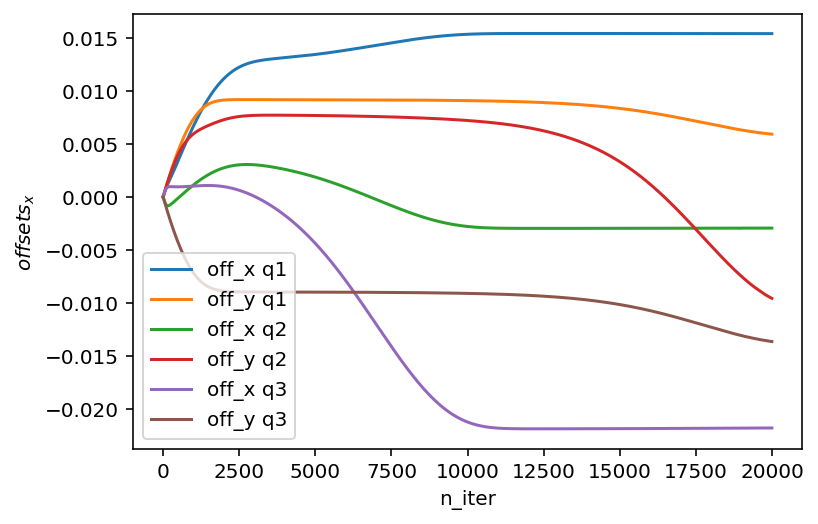

<Figure size 432x288 with 0 Axes>

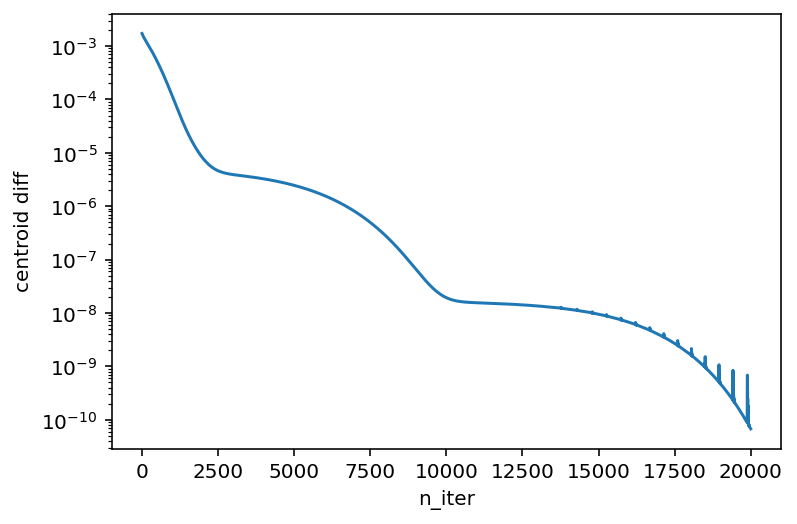

In [27]:
for i in range(len(k1s_opt)):
    plt.plot(n_iter, offsets_x_iter[:,i], label='off_x q'+str(i+1))
    plt.plot(n_iter, offsets_y_iter[:,i], label='off_y q'+str(i+1))
    
plt.legend()
plt.ylabel(r'$offsets_x$')
plt.xlabel('n_iter')
plt.figure()

fig, ax = plt.subplots()
ax.plot(n_iter, loss2)
ax.set_yscale('log')
ax.set_ylabel(r'centroid diff')
ax.set_xlabel('n_iter')

In [28]:
(torch.tensor(params2[-1]['offsets_x'].data), offsets_x_true)

(tensor([1.5410956926643848e-02, -2.9362626373767853e-03, -2.1794367581605911e-02]),
 tensor([1.5409961082440433e-02, -2.9342890576094637e-03, -2.1787893820745575e-02],
        dtype=torch.float64))

In [29]:
(torch.tensor(params2[-1]['offsets_y'].data), offsets_y_true)

(tensor([5.9258788824081421e-03, -9.5641976222395897e-03, -1.3639842160046101e-02]),
 tensor([5.6843127728066776e-03, -1.0845223424240210e-02, -1.3985953953708767e-02],
        dtype=torch.float64))